In [3]:
from functools import partial
import numpy as np
import math
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import MNIST
import sys
from IPython.display import clear_output
import torch.nn.functional as F
import pandas as pd

In [4]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [5]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Adam
**Инициализация:**
$$
m_0 = 0,\quad v_0 = 0
$$

**На каждом шаге $t$:**
$$
\begin{aligned}
g_t &= \nabla_\theta J_{i}(\theta_{t-1}) \\
m_t &= \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t \\
v_t &= \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_t &= \theta_{t-1} - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{aligned}
$$

#### AdamW
#### Добавляем регуляризацию
$$
\begin{aligned}
\theta_t &= \theta_{t-1} - \eta \left( \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} + \lambda \theta_{t-1} \right)
\end{aligned}
$$

In [6]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.00, adamw=False):
        super().__init__(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.adamw = adamw # Флаг Адам и АдамW

        self.states = []
        for p in self.params:
            self.states.append({
                'step': 0,
                'm': torch.zeros_like(p.data),
                'v': torch.zeros_like(p.data)
            })

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                grad = p.grad.data
                state = self.states[i]

                if self.adamw and self.weight_decay != 0:
                    p.data.mul_(1 - self.lr * self.weight_decay)

                state['step'] += 1
                t = state['step']

                state['m'] = self.beta1 * state['m'] + (1 - self.beta1) * grad
                state['v'] = self.beta2 * state['v'] + (1 - self.beta2) * grad**2

                m_hat = state['m'] / (1 - self.beta1**t)
                v_hat = state['v'] / (1 - self.beta2**t)

                p.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

                if not self.adamw and self.weight_decay != 0:
                    p.data -= self.lr * self.weight_decay * p.data

In [7]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer
        self.last_epoch = 0


    def step(self):
        self.last_epoch += 1

In [8]:
class LinearLR(LRScheduler):
    def __init__(self, optimizer, start_factor: float = 0.1, end_factor: float = 1.0, total_iters: int = 100):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters

        self.base_lr = optimizer.lr
        self.start_lr = self.base_lr * start_factor
        self.end_lr = self.base_lr * end_factor


    def step(self):
        super().step()

        if self.last_epoch <= self.total_iters:
            progress = self.last_epoch / self.total_iters
            new_lr = self.start_lr + progress * (self.end_lr - self.start_lr)
        else:
            new_lr = self.end_lr

        self.optimizer.lr = new_lr

In [9]:
class CosineAnnealing(LRScheduler):
    def __init__(self, optimizer, T_max: int = 20, eta_min: float = 0.01):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min
        self.base_lr = optimizer.lr


    def step(self):
        super().step()

        if self.last_epoch < self.T_max:
            cos_value = (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2
            new_lr = self.eta_min + (self.base_lr - self.eta_min) * cos_value
        else:
            new_lr = self.eta_min

        self.optimizer.lr = new_lr

In [10]:
def train(model, optimizer, n_epochs=5, verbose=True, scheduler=None):
    """
    Функция для обучения модели. Использует выборки train, val, test.
    Loss в процессе обучения вычисляется на val.
    На выходе:
    loss_list - ошибка в процессе обучения
    val_accuracy_list - accuracy в процессе обучения
    iteration_list - кол-во итераций
    learning_rates - lr, при использовании оптимизаторов lr меняется на каждой эпоху
    test_loss - ошибка на тесте
    test_accuracy - accuracy на тесте
    """
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

    loss_list = []
    val_accuracy_list = []
    iteration_list = []
    learning_rates = []
    count = 0

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        epoch_batches = 0

        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = F.nll_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            count += 1
            epoch_loss += loss.item()
            epoch_batches += 1

            if count % 200 == 0:
                correct = 0
                total = 0

                model.eval()
                with torch.no_grad():
                    for val_images, val_labels in val_loader:
                        val_outputs = model(val_images)
                        predicted = torch.argmax(val_outputs.data, 1)
                        total += val_labels.size(0)
                        correct += (predicted == val_labels).sum().item()

                val_accuracy = 100 * correct / total

                loss_list.append(loss.item())
                val_accuracy_list.append(val_accuracy)
                iteration_list.append(count)
                learning_rates.append(optimizer.lr)

                if count % 500 == 0 and verbose:
                    print('Iteration: {}  Loss: {:.4f}  Val Accuracy: {:.2f}%  LR: {:.6f}'.format(
                        count, loss.item(), val_accuracy, optimizer.lr))

                model.train()

        epoch_val_accuracy = validate(model, val_loader)
        avg_epoch_loss = epoch_loss / epoch_batches

        if scheduler:
            scheduler.step()

        if verbose:
            current_lr = optimizer.lr
            print(f'Epoch {epoch+1}/{n_epochs} completed. '
                  f'Avg Loss: {avg_epoch_loss:.4f}, '
                  f'Val Accuracy: {epoch_val_accuracy:.2f}%, '
                  f'LR: {current_lr:.6f}')

    test_loss, test_accuracy = test(model, test_loader)

    if verbose:
        print(f'Training completed! Total iterations: {count}')
        print('=' * 60)
        print('FINAL TEST RESULTS:')
        print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))
        print('=' * 60)

    return loss_list, val_accuracy_list, iteration_list, learning_rates, test_loss, test_accuracy



def validate(model, val_loader):
    """Валидация на validation данных"""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    model.train()
    return accuracy


def test(model, test_loader):
    """Финальный тест на test данных"""
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            test_loss += F.nll_loss(outputs, labels, reduction='sum').item()
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_loss = test_loss / total
    return test_loss, accuracy

In [11]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.2MB/s]


Обучим CNN с одним сверточным и pooling слоями. На выходе будем преобразовывать в вектор и использовать функцию активации ReLU. В качестве ошибки будем использовать NLLLos() и для этого будем преобразовывать выход с помощью softmax.


In [12]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)  # ОБЯЗАТЕЛЬНО для NLLLoss!
  )
optimizer1 = SGD(model.parameters(), lr=0.001)

In [13]:

loss_listGD, accuracy_listGD, iteration_listGD, learning_ratesGD, test_lossGD, test_accuracyGD = train(
    model, optimizer1, n_epochs=7
)

Epoch 1/7 completed. Avg Loss: 2.2374, Val Accuracy: 38.55%, LR: 0.001000
Epoch 2/7 completed. Avg Loss: 2.0474, Val Accuracy: 65.97%, LR: 0.001000
Iteration: 1000  Loss: 1.7813  Val Accuracy: 69.42%  LR: 0.001000
Epoch 3/7 completed. Avg Loss: 1.6917, Val Accuracy: 73.00%, LR: 0.001000
Epoch 4/7 completed. Avg Loss: 1.1971, Val Accuracy: 78.37%, LR: 0.001000
Iteration: 2000  Loss: 0.7020  Val Accuracy: 81.60%  LR: 0.001000
Epoch 5/7 completed. Avg Loss: 0.8478, Val Accuracy: 82.45%, LR: 0.001000
Epoch 6/7 completed. Avg Loss: 0.6649, Val Accuracy: 84.87%, LR: 0.001000
Epoch 7/7 completed. Avg Loss: 0.5594, Val Accuracy: 86.32%, LR: 0.001000
Training completed! Total iterations: 2954
FINAL TEST RESULTS:
Test Loss: 0.5042, Test Accuracy: 87.09%


In [14]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)  # ОБЯЗАТЕЛЬНО для NLLLoss!
  )
optimizer2 = Adam(
    params=model.parameters(),
    lr=0.0001,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.00,
    adamw=False
)

In [15]:
loss_listAdam, accuracy_listAdam, iteration_listAdam, learning_ratesAdam, test_lossAdam, test_accuracyAdam = train(
    model, optimizer2, n_epochs=7
)

Epoch 1/7 completed. Avg Loss: 1.1246, Val Accuracy: 89.85%, LR: 0.000100
Epoch 2/7 completed. Avg Loss: 0.3158, Val Accuracy: 93.77%, LR: 0.000100
Iteration: 1000  Loss: 0.2202  Val Accuracy: 94.27%  LR: 0.000100
Epoch 3/7 completed. Avg Loss: 0.2027, Val Accuracy: 95.23%, LR: 0.000100
Epoch 4/7 completed. Avg Loss: 0.1553, Val Accuracy: 96.08%, LR: 0.000100
Iteration: 2000  Loss: 0.1562  Val Accuracy: 96.60%  LR: 0.000100
Epoch 5/7 completed. Avg Loss: 0.1283, Val Accuracy: 96.70%, LR: 0.000100
Epoch 6/7 completed. Avg Loss: 0.1109, Val Accuracy: 97.12%, LR: 0.000100
Epoch 7/7 completed. Avg Loss: 0.0988, Val Accuracy: 97.42%, LR: 0.000100
Training completed! Total iterations: 2954
FINAL TEST RESULTS:
Test Loss: 0.0854, Test Accuracy: 97.54%


In [16]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)  # ОБЯЗАТЕЛЬНО для NLLLoss!
  )
optimizer3 = Adam(
    params=model.parameters(),
    lr=0.0001,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.001,
    adamw=True
)

In [17]:
loss_listAdamW, accuracy_listAdamW, iteration_listAdamW, learning_ratesAdamW, test_lossAdamW, test_accuracyAdamW = train(
    model, optimizer3, n_epochs=7
)

Epoch 1/7 completed. Avg Loss: 1.0958, Val Accuracy: 88.63%, LR: 0.000100
Epoch 2/7 completed. Avg Loss: 0.3464, Val Accuracy: 92.20%, LR: 0.000100
Iteration: 1000  Loss: 0.2667  Val Accuracy: 92.92%  LR: 0.000100
Epoch 3/7 completed. Avg Loss: 0.2318, Val Accuracy: 93.87%, LR: 0.000100
Epoch 4/7 completed. Avg Loss: 0.1795, Val Accuracy: 94.90%, LR: 0.000100
Iteration: 2000  Loss: 0.1251  Val Accuracy: 95.55%  LR: 0.000100
Epoch 5/7 completed. Avg Loss: 0.1475, Val Accuracy: 95.68%, LR: 0.000100
Epoch 6/7 completed. Avg Loss: 0.1265, Val Accuracy: 96.20%, LR: 0.000100
Epoch 7/7 completed. Avg Loss: 0.1115, Val Accuracy: 96.75%, LR: 0.000100
Training completed! Total iterations: 2954
FINAL TEST RESULTS:
Test Loss: 0.0984, Test Accuracy: 97.01%


In [18]:
def plot_training_metrics(iterations, loss_adamw, loss_adam, loss_sgd,
                         accuracy_adamw, accuracy_adam, accuracy_sgd):
    # Создаем фигуру с 3 графиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # График 1: Loss
    ax1.plot(iterations, loss_adamw, label='AdamW')
    ax1.plot(iterations, loss_adam, label='Adam')
    ax1.plot(iterations, loss_sgd, label='SGD')
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss")
    ax1.legend()
    ax1.grid(True)
    ax1.set_yscale('log')

    # График 2: Accuracy
    ax2.plot(iterations, accuracy_adamw, label='AdamW')
    ax2.plot(iterations, accuracy_adam, label='Adam')
    ax2.plot(iterations, accuracy_sgd, label='SGD')
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_title("Accuracy")
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, 100)


    plt.tight_layout()
    plt.show()

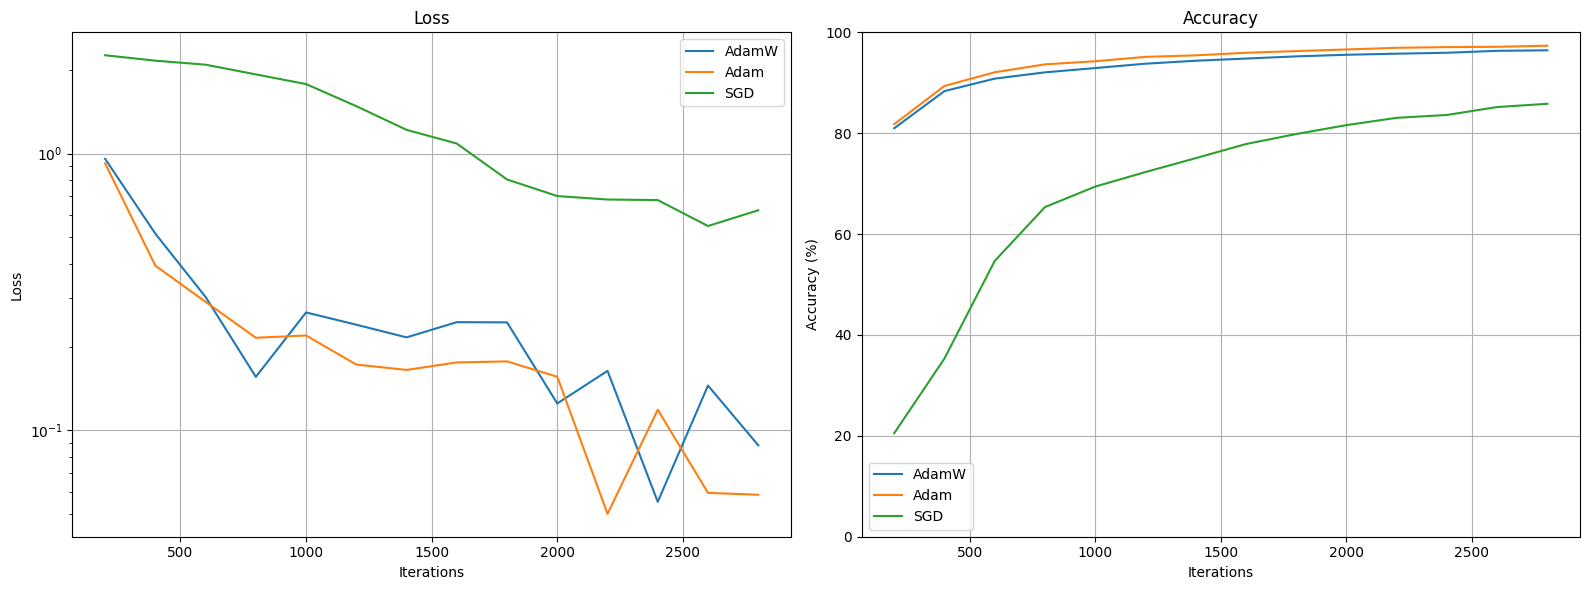

In [19]:
plot_training_metrics(
    iteration_listAdamW,     # iterations
    loss_listAdamW,          # loss_adamw
    loss_listAdam,           # loss_adam
    loss_listGD,             # loss_sgd
    accuracy_listAdamW,      # accuracy_adamw
    accuracy_listAdam,       # accuracy_adam
    accuracy_listGD          # accuracy_sgd
)

In [20]:
model1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)  # ОБЯЗАТЕЛЬНО для NLLLoss!
  )
optimizer1 = SGD(model1.parameters(), lr=0.01)
scheduler1 = LinearLR(
    optimizer=optimizer1,
    start_factor=1.0,
    end_factor=0.1,      # Уменьшаем до 10%
    total_iters=7     # Изменение между эпохами
)

model2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)  # ОБЯЗАТЕЛЬНО для NLLLoss!
  )
optimizer2 = Adam(
    params=model2.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.00,
    adamw=False
)
scheduler2 = LinearLR(
    optimizer=optimizer2,
    start_factor=1.0,
    end_factor=0.1,
    total_iters=7
)

model3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)  # ОБЯЗАТЕЛЬНО для NLLLoss!
  )
optimizer3 = Adam(
    params=model3.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.0001,
    adamw=True
)

scheduler3 = LinearLR(
    optimizer=optimizer3,
    start_factor=1.0,
    end_factor=0.1,
    total_iters=7
)



In [21]:
loss_listGD_Line, accuracy_listGD_Line, iteration_listGD_Line, learning_ratesGD_Line, test_lossGD_Line, test_accuracyGD_Line = train(
    model1, optimizer1, n_epochs=7, scheduler=scheduler1
)

Epoch 1/7 completed. Avg Loss: 0.9278, Val Accuracy: 91.73%, LR: 0.008714
Epoch 2/7 completed. Avg Loss: 0.2681, Val Accuracy: 93.72%, LR: 0.007429
Iteration: 1000  Loss: 0.2935  Val Accuracy: 94.62%  LR: 0.007429
Epoch 3/7 completed. Avg Loss: 0.2056, Val Accuracy: 94.90%, LR: 0.006143
Epoch 4/7 completed. Avg Loss: 0.1758, Val Accuracy: 95.40%, LR: 0.004857
Iteration: 2000  Loss: 0.1720  Val Accuracy: 95.80%  LR: 0.004857
Epoch 5/7 completed. Avg Loss: 0.1585, Val Accuracy: 95.87%, LR: 0.003571
Epoch 6/7 completed. Avg Loss: 0.1477, Val Accuracy: 96.07%, LR: 0.002286
Epoch 7/7 completed. Avg Loss: 0.1408, Val Accuracy: 96.13%, LR: 0.001000
Training completed! Total iterations: 2954
FINAL TEST RESULTS:
Test Loss: 0.1294, Test Accuracy: 96.15%


In [22]:
loss_listAdam_Line, accuracy_listAdam_Line, iteration_listAdam_Line, learning_ratesAdam_Line, test_lossAdam_Line, test_accuracyAdam_Line = train(
    model2, optimizer2, n_epochs=7, scheduler=scheduler2
)

Epoch 1/7 completed. Avg Loss: 0.2847, Val Accuracy: 97.15%, LR: 0.000871
Epoch 2/7 completed. Avg Loss: 0.0861, Val Accuracy: 97.40%, LR: 0.000743
Iteration: 1000  Loss: 0.0675  Val Accuracy: 97.92%  LR: 0.000743
Epoch 3/7 completed. Avg Loss: 0.0632, Val Accuracy: 98.05%, LR: 0.000614
Epoch 4/7 completed. Avg Loss: 0.0524, Val Accuracy: 98.20%, LR: 0.000486
Iteration: 2000  Loss: 0.1278  Val Accuracy: 98.47%  LR: 0.000486
Epoch 5/7 completed. Avg Loss: 0.0426, Val Accuracy: 98.23%, LR: 0.000357
Epoch 6/7 completed. Avg Loss: 0.0373, Val Accuracy: 98.63%, LR: 0.000229
Epoch 7/7 completed. Avg Loss: 0.0324, Val Accuracy: 98.58%, LR: 0.000100
Training completed! Total iterations: 2954
FINAL TEST RESULTS:
Test Loss: 0.0397, Test Accuracy: 98.70%


In [23]:
loss_listAdamW_Line, accuracy_listAdamW_Line, iteration_listAdamW_Line, learning_ratesAdamW_Line, test_lossAdamW_Line, test_accuracyAdamW_Line = train(
    model3, optimizer3, n_epochs=7, scheduler=scheduler3
)

Epoch 1/7 completed. Avg Loss: 0.2905, Val Accuracy: 97.05%, LR: 0.000871
Epoch 2/7 completed. Avg Loss: 0.0874, Val Accuracy: 98.05%, LR: 0.000743
Iteration: 1000  Loss: 0.0442  Val Accuracy: 98.15%  LR: 0.000743
Epoch 3/7 completed. Avg Loss: 0.0661, Val Accuracy: 98.08%, LR: 0.000614
Epoch 4/7 completed. Avg Loss: 0.0545, Val Accuracy: 98.25%, LR: 0.000486
Iteration: 2000  Loss: 0.0303  Val Accuracy: 98.60%  LR: 0.000486
Epoch 5/7 completed. Avg Loss: 0.0444, Val Accuracy: 98.58%, LR: 0.000357
Epoch 6/7 completed. Avg Loss: 0.0392, Val Accuracy: 98.52%, LR: 0.000229
Epoch 7/7 completed. Avg Loss: 0.0335, Val Accuracy: 98.70%, LR: 0.000100
Training completed! Total iterations: 2954
FINAL TEST RESULTS:
Test Loss: 0.0401, Test Accuracy: 98.61%


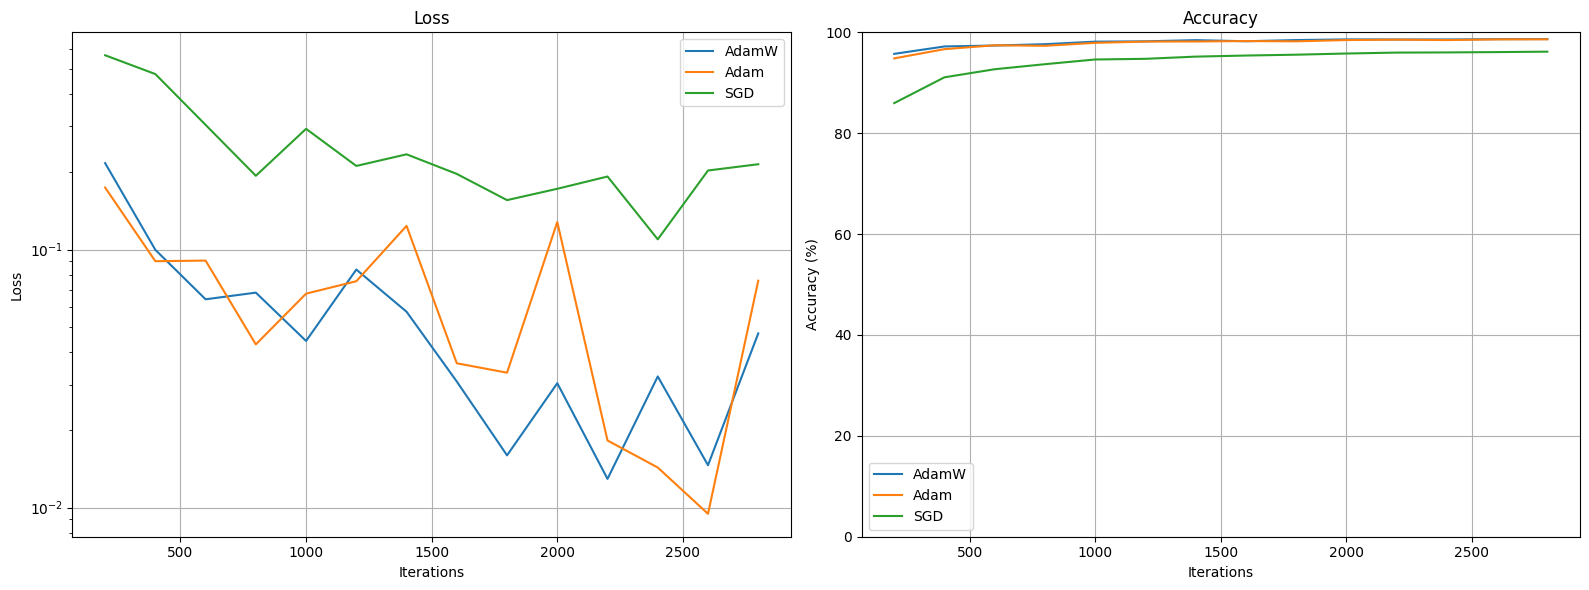

In [24]:
plot_training_metrics(
    iteration_listAdamW_Line,        # iterations
    loss_listAdamW_Line,             # loss_adamw
    loss_listAdam_Line,              # loss_adam
    loss_listGD_Line,                # loss_sgd
    accuracy_listAdamW_Line,         # accuracy_adamw
    accuracy_listAdam_Line,          # accuracy_adam
    accuracy_listGD_Line             # accuracy_sgd
)

In [25]:
model1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)  # ОБЯЗАТЕЛЬНО для NLLLoss!
  )
optimizer1 = SGD(model1.parameters(), lr=0.01)
scheduler1 = CosineAnnealing(
    optimizer=optimizer1,
    T_max = 7,
    eta_min= 0.0001
)

model2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)  # ОБЯЗАТЕЛЬНО для NLLLoss!
  )
optimizer2 = Adam(
    params=model2.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.00,
    adamw=False
)
scheduler2 = CosineAnnealing(
    optimizer=optimizer2,
    T_max = 7,
    eta_min= 1e-5
)

model3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)  # ОБЯЗАТЕЛЬНО для NLLLoss!
  )
optimizer3 = Adam(
    params=model3.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.001,
    adamw=True
)

scheduler3 = CosineAnnealing(
    optimizer=optimizer3,
    T_max = 7,
    eta_min= 1e-5
)



In [26]:
loss_listGD_Cos, accuracy_listGD_Cos, iteration_listGD_Cos, learning_ratesGD_Cos, test_lossGD_Cos, test_accuracyGD_Cos = train(
    model1, optimizer1, n_epochs=7, scheduler=scheduler1
)

Epoch 1/7 completed. Avg Loss: 0.8773, Val Accuracy: 90.50%, LR: 0.009510
Epoch 2/7 completed. Avg Loss: 0.2647, Val Accuracy: 93.77%, LR: 0.008136
Iteration: 1000  Loss: 0.1512  Val Accuracy: 94.05%  LR: 0.008136
Epoch 3/7 completed. Avg Loss: 0.1928, Val Accuracy: 94.70%, LR: 0.006151
Epoch 4/7 completed. Avg Loss: 0.1611, Val Accuracy: 95.30%, LR: 0.003949
Iteration: 2000  Loss: 0.1285  Val Accuracy: 95.48%  LR: 0.003949
Epoch 5/7 completed. Avg Loss: 0.1445, Val Accuracy: 95.73%, LR: 0.001964
Epoch 6/7 completed. Avg Loss: 0.1362, Val Accuracy: 95.82%, LR: 0.000590
Epoch 7/7 completed. Avg Loss: 0.1327, Val Accuracy: 95.85%, LR: 0.000100
Training completed! Total iterations: 2954
FINAL TEST RESULTS:
Test Loss: 0.1231, Test Accuracy: 96.76%


In [27]:
loss_listAdam_Cos, accuracy_listAdam_Cos, iteration_listAdam_Cos, learning_ratesAdam_Cos, test_lossAdam_Cos, test_accuracyAdam_Cos = train(
    model2, optimizer2, n_epochs=7, scheduler=scheduler2
)

Epoch 1/7 completed. Avg Loss: 0.3160, Val Accuracy: 96.78%, LR: 0.000951
Epoch 2/7 completed. Avg Loss: 0.0973, Val Accuracy: 97.67%, LR: 0.000814
Iteration: 1000  Loss: 0.0318  Val Accuracy: 97.52%  LR: 0.000814
Epoch 3/7 completed. Avg Loss: 0.0678, Val Accuracy: 98.07%, LR: 0.000615
Epoch 4/7 completed. Avg Loss: 0.0542, Val Accuracy: 98.20%, LR: 0.000395
Iteration: 2000  Loss: 0.0469  Val Accuracy: 98.15%  LR: 0.000395
Epoch 5/7 completed. Avg Loss: 0.0443, Val Accuracy: 98.15%, LR: 0.000196
Epoch 6/7 completed. Avg Loss: 0.0380, Val Accuracy: 98.23%, LR: 0.000059
Epoch 7/7 completed. Avg Loss: 0.0339, Val Accuracy: 98.48%, LR: 0.000010
Training completed! Total iterations: 2954
FINAL TEST RESULTS:
Test Loss: 0.0390, Test Accuracy: 98.77%


In [28]:
loss_listAdamW_Cos, accuracy_listAdamW_Cos, iteration_listAdamW_Cos, learning_ratesAdamW_Cos, test_lossAdamW_Cos, test_accuracyAdamW_Cos = train(
    model3, optimizer3, n_epochs=7, scheduler=scheduler3
)

Epoch 1/7 completed. Avg Loss: 0.3181, Val Accuracy: 96.53%, LR: 0.000951
Epoch 2/7 completed. Avg Loss: 0.0938, Val Accuracy: 97.02%, LR: 0.000814
Iteration: 1000  Loss: 0.0370  Val Accuracy: 97.67%  LR: 0.000814
Epoch 3/7 completed. Avg Loss: 0.0702, Val Accuracy: 98.03%, LR: 0.000615
Epoch 4/7 completed. Avg Loss: 0.0538, Val Accuracy: 98.18%, LR: 0.000395
Iteration: 2000  Loss: 0.0262  Val Accuracy: 98.35%  LR: 0.000395
Epoch 5/7 completed. Avg Loss: 0.0445, Val Accuracy: 98.28%, LR: 0.000196
Epoch 6/7 completed. Avg Loss: 0.0383, Val Accuracy: 98.52%, LR: 0.000059
Epoch 7/7 completed. Avg Loss: 0.0343, Val Accuracy: 98.58%, LR: 0.000010
Training completed! Total iterations: 2954
FINAL TEST RESULTS:
Test Loss: 0.0405, Test Accuracy: 98.68%


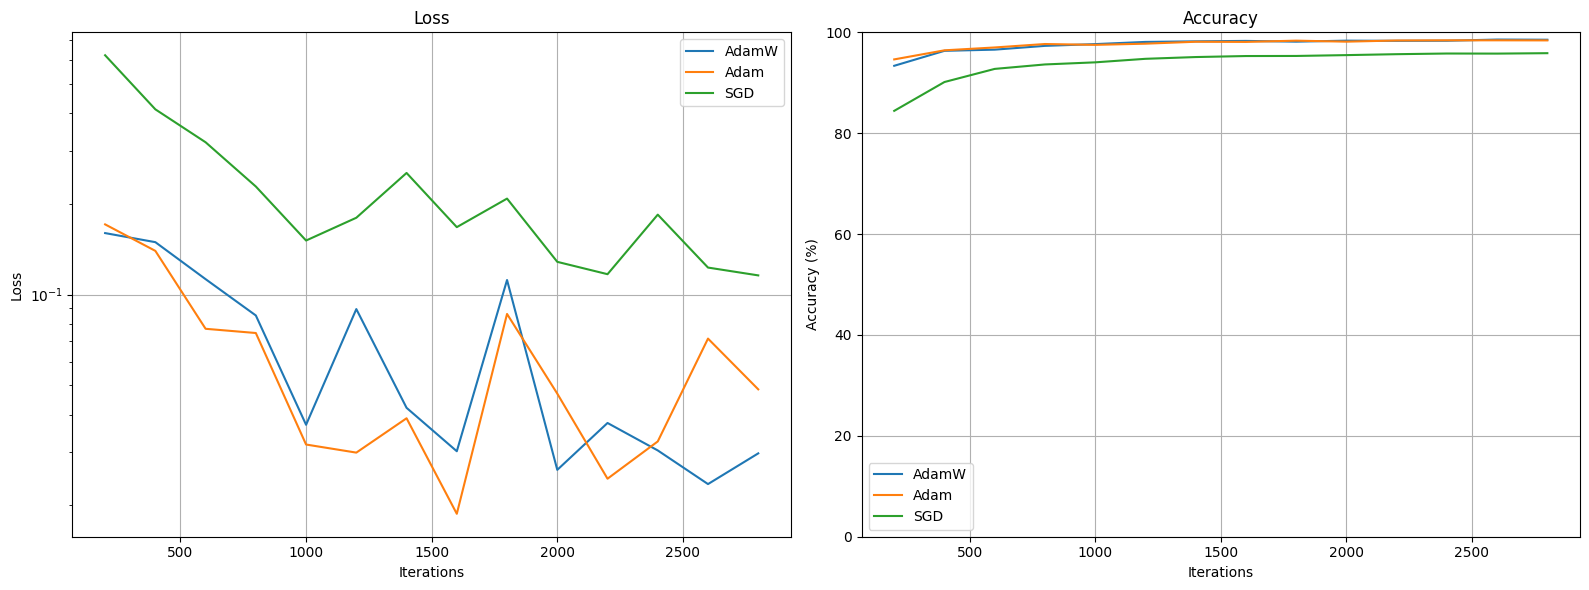

In [29]:
plot_training_metrics(
    iteration_listAdamW_Cos,        # iterations
    loss_listAdamW_Cos,             # loss_adamw
    loss_listAdam_Cos,              # loss_adam
    loss_listGD_Cos,                # loss_sgd
    accuracy_listAdamW_Cos,         # accuracy_adamw
    accuracy_listAdam_Cos,          # accuracy_adam
    accuracy_listGD_Cos             # accuracy_sgd
)

In [30]:
results = {
    'Method': [
        'SGD (no scheduler)',
        'SGD + LinearLR',
        'SGD + Cosine',
        'Adam (no scheduler)',
        'Adam + LinearLR',
        'Adam + Cosine',
        'AdamW (no scheduler)',
        'AdamW + LinearLR',
        'AdamW + Cosine'
    ],
    'Test Loss': [
        test_lossGD,           # SGD без scheduler
        test_lossGD_Line,      # SGD + LinearLR
        test_lossGD_Cos,       # SGD + Cosine
        test_lossAdam,         # Adam без scheduler
        test_lossAdam_Line,    # Adam + LinearLR
        test_lossAdam_Cos,     # Adam + Cosine
        test_lossAdamW,        # AdamW без scheduler
        test_lossAdamW_Line,   # AdamW + LinearLR
        test_lossAdamW_Cos     # AdamW + Cosine
    ],
    'Test Accuracy': [
        test_accuracyGD,           # SGD без scheduler
        test_accuracyGD_Line,      # SGD + LinearLR
        test_accuracyGD_Cos,       # SGD + Cosine
        test_accuracyAdam,         # Adam без scheduler
        test_accuracyAdam_Line,    # Adam + LinearLR
        test_accuracyAdam_Cos,     # Adam + Cosine
        test_accuracyAdamW,        # AdamW без scheduler
        test_accuracyAdamW_Line,   # AdamW + LinearLR
        test_accuracyAdamW_Cos     # AdamW + Cosine
    ]
}

df_results = pd.DataFrame(results)

df_sorted = df_results.sort_values('Test Accuracy', ascending=False)

print('=' * 60)
print('СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ')
print('=' * 60)
print(df_sorted.to_string(index=False, float_format='%.4f'))
print('=' * 60)

best_method = df_sorted.iloc[0]
print(f"🏆 ЛУЧШИЙ РЕЗУЛЬТАТ: {best_method['Method']}")
print(f"   Accuracy: {best_method['Test Accuracy']:.2f}%")
print(f"   Loss: {best_method['Test Loss']:.4f}")

СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
              Method  Test Loss  Test Accuracy
       Adam + Cosine     0.0390        98.7700
     Adam + LinearLR     0.0397        98.7000
      AdamW + Cosine     0.0405        98.6800
    AdamW + LinearLR     0.0401        98.6100
 Adam (no scheduler)     0.0854        97.5400
AdamW (no scheduler)     0.0984        97.0100
        SGD + Cosine     0.1231        96.7600
      SGD + LinearLR     0.1294        96.1500
  SGD (no scheduler)     0.5042        87.0900
🏆 ЛУЧШИЙ РЕЗУЛЬТАТ: Adam + Cosine
   Accuracy: 98.77%
   Loss: 0.0390


Некоторые выводы:

* Дольше всего обучается модель на SGD. Ошибка падает медленее, но плавнее и для обучения модели необходимо большее кол-во итераций. При использовании scheduler ошибка падет в два раза и это очень хороший результат.

* Adam и AdamW с постоянным lr дает почти одинаковый результат и при использовании scheduler ошибка падает в 2 раза.

* Cosine и LinearLR дают во всех 6 случаях уменьшение ошибки в 2 раза, но между собой они различаются незначительно. LinearLR лучше использовать в простых задачах, тк он простой и имеет меньше параметров. Cosine требует большей настройки и использовать его стоит когда LinearLR не дает хороших результатов.




Что можно улучьшить:

* Поиграться с настройками CNN.

* Добавить early stopping


